# Main

This jupyter notebook aims at giving a `craftai.pandas` use case to the user.

The work is based on the dataset `yellow.csv` located in the directory _data/_. (It is possible to regenerate this dataset by using the notebook `Preprocessing.ipynb`.)

`yellow.csv` has been extracted from the data available on the ___NYC Taxi and Limousine Commission (LTC)___ [webpage](http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml).

__Goal__:
The user is a NYC taxi driver who wants to know in the next hours where to drive to maximize his chances to find a client. 

In [234]:
import craftai.pandas
import pandas as pd
import numpy as np
import os

import Tools

import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

In [235]:
FIGSIZE = (17, 5)
FONT = {"family": "sans-serif", "weight": "normal", "size": 16}

init_notebook_mode(connected=True)

## 1. `Yellow` dataset handling

### 1.1. Load `yellow` Dataset

`yellow` contains the number of yellow taxis hired for each `taxi_zone` at a hourly time for the whole year 2017.
Columns names refer to zone ids, and the whole dataframe is indexed on time. The column `timezone` is needed to indicate the index timezone (which is New York).

In [236]:
PATH = '../data/' # Modify this to fit your data folder

In [237]:
yellow = pd.read_csv(PATH + "yellow.csv")
yellow.columns = yellow.columns[1:].insert(0, "timestamp")
yellow.timestamp = pd.to_datetime(yellow.timestamp, utc=True)
yellow.set_index("timestamp", drop=True, inplace=True)
yellow.index = yellow.index.tz_convert("America/New_York")

In [238]:
yellow.head()

timezone    1    2    3     4    5    6     7    8  \
timestamp                                                                      
2017-01-01 00:00:00-05:00   -05:00  2.0  0.0  0.0  54.0  0.0  0.0  66.0  0.0   
2017-01-01 01:00:00-05:00   -05:00  2.0  0.0  0.0  36.0  0.0  0.0  54.0  1.0   
2017-01-01 02:00:00-05:00   -05:00  2.0  0.0  0.0  28.0  0.0  0.0  42.0  0.0   
2017-01-01 03:00:00-05:00   -05:00  0.0  0.0  0.0  36.0  0.0  0.0  26.0  0.0   
2017-01-01 04:00:00-05:00   -05:00  0.0  0.0  0.0  34.0  0.0  0.0  33.0  0.0   

                             9  ...    256  257  258  259   260   261   262  \
timestamp                       ...                                           
2017-01-01 00:00:00-05:00  0.0  ...   50.0  1.0  0.0  2.0  49.0  23.0  35.0   
2017-01-01 01:00:00-05:00  0.0  ...   30.0  0.0  4.0  2.0  31.0  17.0  49.0   
2017-01-01 02:00:00-05:00  0.0  ...    6.0  0.0  0.0  0.0  16.0  14.0  72.0   
2017-01-01 03:00:00-05:00  0.0  ...    7.0  0.0  1.0  0.0   7.0  10.0  75.0   
2017-01-01 04:00:00-05:00  0.0  ...    4.0  1.0  0.0  0.0  14.0  28.0  97.0   

                             263    264   265  
timestamp                                      
2017-01-01 00:00:00-05:00  133.0  135.0  13.0  
2017-01-01 01:00:00-05:00  106.0   86.0  10.0  
2017-01-01 02:00:00-05:00   92.0   80.0   6.0  
2017-01-01 03:00:00-05:00  105.0   66.0   4.0  
2017-01-01 04:00:00-05:00  131.0   91.0   2.0  

[5 rows x 266 columns]

### 1.2. Focus on Queens areas (Recommended)

__If you want to compute all the taxi zones, skip the following cell.__

To save computation time, we only focus on 5 of the 69 Queens taxi zones.

<img src="http://www.nyc.gov/html/tlc/images/features/taxi_zone_map_queens.jpg" title="Queens Taxi Zones" alt="Bronx Taxi Zones" style="width: 300px;"/>

The selected taxi zones are the following: $7$, $145$, $146$, $193$, $226$ (NW areas).

In [239]:
selected_zones = [7, 145, 146, 193, 226] # Modify this list to fit your needs
selected_zones_str = [str(z) for z in selected_zones]

columns = ["timezone"] + selected_zones_str
yellow = yellow[columns]

### 1.3. Dataset visualization

Let's have look to what the dataset looks like:

In [240]:
# To display without timezone shifting
utc_index = pd.date_range("2017-01-01 00:00", 
                          "2017-12-31 23:00", freq="h") 

#### 1.3.1. Static visualization (available on github)

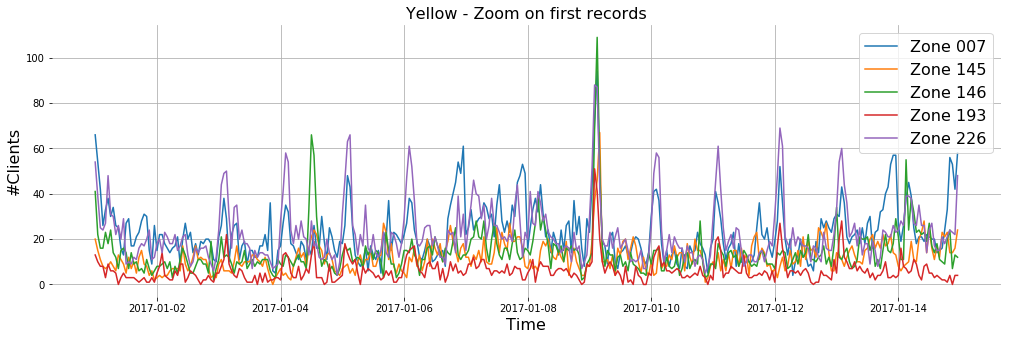

In [241]:
nb_records_to_display = 2*7*24 # display two weeks

fig, ax = plt.subplots(figsize=FIGSIZE)

for agent_id_col in selected_zones:
    plt.plot(utc_index[:nb_records_to_display],
            yellow[str(agent_id_col)].values[:nb_records_to_display],
            label="Zone {:0>3}".format(agent_id_col))
    

plt.title("Yellow - Zoom on first records", fontdict=FONT)
plt.xlabel("Time", fontdict=FONT)
plt.ylabel("#Clients", fontdict=FONT)

ax.set_frame_on(False)
plt.grid(True)
plt.legend(prop={"size": FONT["size"]})
plt.show()

#### 1.3.2. Interactive visualization (available when the notebook is running)

The user can zoom, select and navigate through the linechart.

In [242]:
data = []

for agent_id_col in selected_zones:
    data.append(go.Scatter(
        x = utc_index,      
        y = yellow[str(agent_id_col)].values,
        name = "Zone {:0>3}".format(agent_id_col),
        line=dict(color="hsla(0,0,0%)")
    ))

layout = {"title": "Yellow - Data Exploration",
          "xaxis": { "title":"Time" },
          "yaxis": { "title":"#Clients" },
          "font": dict(size=16)}
    
iplot({"data": data,
       "layout": layout})

### 1.4. Creating `train`/`test` sets

In [243]:
start = pd.to_datetime("2017-12-04 00:00")
train = yellow[:start]
test = yellow[start:pd.to_datetime("2017-12-17 23:00")]

## 2. Connect to craftai api

Open a link to the Craft AI API by creating a `client` based on user's token. 

If you do not have a token yet, <a href='https://beta.craft.ai/inspector'>create a project</a> and past your `Write API token` in a file named `.env` like the following:
```sh
 CRAFT_TOKEN=your-token
```

_This file should be at the root of your cloned project. You might have to rerun the `pipenv run notebook` after filling the `.env` file._

In [244]:
client = craftai.pandas.Client({
  "token": os.environ.get("CRAFT_TOKEN")
})

## 3. Setup Prediction

In this work each taxi zone is computed by an Agent. In other words, Agent `taxi_zone_007` is supposed to learn from zone 7's historical records to predict potential taxi needs in this zone.

### 3.1. Initiate Agents
First we create a DataFrame `agents` that will store zone ids, alongside with our agent ids and all kind of results. 

In [245]:
agents = pd.DataFrame(
    data={
        "zone": selected_zones,
        "agent_id": ["taxi_zone_{:0>3}".format(z) for z in selected_zones]
    }
)
agents.head()

zone       agent_id
0     7  taxi_zone_007
1   145  taxi_zone_145
2   146  taxi_zone_146
3   193  taxi_zone_193
4   226  taxi_zone_226

It's now time to setup our agents' context. In this work the configuration context is shared by all agents. 

`CONFIGURATION` indicates to the API what are the inputs features and which feature(s) we want to predict.

In [246]:
# CONFIGURATION is the same for all agents
CONFIGURATION = {
    "context": {
        "day_of_week": {                # feature generated by the API from the DataFrame index 
            "type" : "day_of_week"
        },
        "time": {                       # feature generated by the API from the DataFrame index
            "type": "time_of_day"
        },
        "timezone": {                   # timezone for trip_counter      
            "type" : "timezone",        
        },
        "trip_counter": {               # taxi trips counter            
            "type": "continuous"
        }
    },
    "output": ["trip_counter"],         # the output is continuous
    "learning_period": 31536000,         # 1 year: 365d * 24h * 3600s
    "tree_max_depth": 10 
}

The following function `setup_agent` aims at creating an Agent on the API and to add the operations associated.

In [247]:
def setup_agent(row):
    """ Initiate Agent with the given id and 
        add the data associated with this zone
    """

    # Delete older version of the agent
    client.delete_agent(row.agent_id)

    # Add the new agent
    client.create_agent(CONFIGURATION, row.agent_id)

    # Add operations
    data = train[["timezone", str(row.zone)]]
    data.columns = ["timezone", "trip_counter"]
    
    ##### Added for Influx benchmarks #####
    import requests
    import six
    import json
    
    DUMMY_COLUMN_NAME = "CraftGeneratedDummy"
    OPTIONAL_VALUE = "OPTIONAL"
    MISSING_VALUE = "MISSING"
    
    _requests_session = requests.Session()
    
    def chunker(to_be_chunked_df, chunk_size):
      return (to_be_chunked_df[pos:pos + chunk_size]
        for pos in range(0, len(to_be_chunked_df), chunk_size))

    def format_input(val):
      if val == MISSING_VALUE:
        return None
      if val == OPTIONAL_VALUE:
        return {}
      return val

    def is_valid_property_value(key, value):
      # From https://stackoverflow.com/a/19773559
      # https://pythonhosted.org/six/#six.text_type for unicode in Python 2
      return key != DUMMY_COLUMN_NAME and \
             ( \
               (not hasattr(value, "__len__") \
                or isinstance(value, (str, six.text_type)) \
                or value == MISSING_VALUE \
                or value == OPTIONAL_VALUE) \
               and pd.notnull(value) \
             )

    def add_operations_influx(agent_id, data):
      chunk_size = 500
    
      for chunk in chunker(data, chunk_size):
        chunk_operations = [
          {
            "timestamp": row.name.value // 10 ** 9, # Timestamp.value returns nanoseconds
            "context": {
              col: format_input(row[col])
              for col in chunk.columns if is_valid_property_value(col, row[col])
            }
          } for _, row in chunk.iterrows()
        ]
        
      ct_header = {"Content-Type": "application/json; charset=utf-8"}
      try:
        json_pl = json.dumps(chunk_operations)
      except TypeError as err:
        raise Exception("Invalid configuration or agent id given. {}"
                                     .format(err.__str__()))

      req_url = "http://localhost:3001/contextops/"
      resp = _requests_session.post(req_url, headers=ct_header, data=json_pl)
      # _decode_response(resp)
    
    client.add_operations = add_operations_influx
    ##### End: Added for Influx benchmarks #####
    client.add_operations(row.agent_id, data)

    return True

In [ ]:
%%time

agents["setup"] = agents.apply(setup_agent, axis=1)

In [ ]:
agents.head()

### 3.2. Retrieve last decision tree

Each Agent learns from its operations. Then we ask the API for the last Decision Tree.

__This step is the most time consuming's one.__


Firstly we choose a timestamp where we want to retrieve our model. In this notebook we want to retrieve the `train` set last decision tree:

In [ ]:
TS = train.index.astype(np.int64).values[-1] // 10**9 #get last timestamp

In [ ]:
# API request. The training starts when the user asks for the decision tree.
get_DT = lambda agent_id : client.get_decision_tree(agent_id, timestamp=TS)

In [ ]:
%%time

agents['decision_tree'] = agents.agent_id.apply(get_DT)

In [ ]:
agents.head()

## 4. Decision's time !

Now that we have retrieved our models, we are able to predict the best place to find clients.


### 4.1. Decision Dataframe setup

First we setup the `DECISION_DF` where the prediction inputs are located. In this work `DECISION_DF` is quite simple: it's just an index with the `timezone` column. Indeed, columns `day_of_week` and `time` are computed by the API from the index.

To evaluate the predictions we are testing our agents on the `test` set. So we are testing our agents on the last year of the year 2017.

In [ ]:
# DECISION_DF is the same for all Agents as we want to compare taxi zones
DECISION_DF = pd.DataFrame(
    ['-05:00' for t in test.index],
    columns=['timezone'],
    index=test.index
)

print("DECISION_DF's head:\n",DECISION_DF.head(1))
print("\n\nDECISION_DF's tail:\n",DECISION_DF.tail(1))

### 4.2. Make Decisions

Ask each Agent to estimate the taxi need for their own `taxi_zone` thanks to the `DECISION_DF`.

In [ ]:
def decide(tree):
    decision = client.decide_from_contexts_df(tree, DECISION_DF)
    return pd.Series({ c: decision[c].values for c in decision.columns })

In [ ]:
agents_with_decisions = agents.merge(
    agents.decision_tree.apply(decide), 
    left_index=True, 
    right_index=True
)

agents_with_decisions.head()

Each decision is explainable. You can analyse the tree directly in your <a href="https://integration.craft.ai/inspector/">project's inspector</a>, or your can print the decision rule that has led to the decision.

In [ ]:
# decision to explain:
agent_id_to_explain = 'taxi_zone_007'
decision_idx_to_explain = 0

line_to_explain = agents_with_decisions[agents_with_decisions.agent_id == agent_id_to_explain]

decision =  line_to_explain.trip_counter_predicted_value.values[0][decision_idx_to_explain]
        
rule_to_explain = line_to_explain.trip_counter_decision_rules.values[0][decision_idx_to_explain]

print('Agent {0} has predicted {1} clients in his zone,\nbecause '
      .format(agent_id_to_explain, decision),
      craftai.format_decision_rules(
          craftai.reduce_decision_rules(rule_to_explain)
      ))

### 4.3. Observe results

In [ ]:
# To display without timezone shifting
utc_test_index = pd.date_range('2017-12-04 00:00', 
                        "2017-12-17 23:00", freq="h") 

Reformat results:

In [ ]:
predictions = pd.DataFrame(
                agents_with_decisions.trip_counter_predicted_value.tolist()
              ).T
predictions.columns = selected_zones_str
predictions.index = test.index
predictions.head()

In [ ]:
# predictions' standard deviation
stds = pd.DataFrame(
                agents_with_decisions.trip_counter_standard_deviation.tolist()
              ).T
stds.columns = selected_zones_str
stds.index = test.index

Static visualization:

In [ ]:
zone = 7

fig, ax = plt.subplots(figsize=FIGSIZE)

plt.plot(utc_test_index, test[str(zone)], label='Reality')
plt.plot(utc_test_index, predictions[str(zone)],
            label='Prediction {:0>3}'.format(zone))

ax.fill_between(utc_test_index, 
                predictions[str(zone)] + stds[str(zone)], 
                predictions[str(zone)] - stds[str(zone)], 
                color='red', alpha=0.15, 
                label='STD {:0>3}'.format(zone))


plt.title('Zone {:0>3} Predictions'.format(zone), fontdict=FONT)
plt.xlabel('Time', fontdict=FONT)
plt.ylabel('#Clients', fontdict=FONT)

ax.set_frame_on(False)
plt.grid(True)
plt.legend(prop={'size': FONT['size']})
plt.show()

To have a deeper analysis, please refer to `Benchmarks.ipynb`.

```python
#save results for benchmark analysis:
predictions.to_csv(PATH + 'craftai.csv')
stds.to_csv(PATH + 'craftai_std.csv')

```

## 5. Conclusion: Evaluate Best Taxi Zone 

Based on all Agents estimations, find the `taxi_zone` with the most persons looking for a taxi. 

In [ ]:
def best_zone(row):
    return agents.zone.values[np.argmax(row.values)]

In [ ]:
predictions['best_zone'] = predictions[selected_zones_str].apply(best_zone, axis=1)

predictions.sample(10).sort_index()

In [ ]:
predictions[predictions['best_zone']==145].head()

Let's have a look to the results:

In [ ]:
nb_hours_to_display = 24 # display the first day

plot_text = {
    'x_tick_labels': selected_zones,
    'y_tick_labels': predictions.index[:nb_hours_to_display],
    'title': 'Where are the clients ?',
    'xlabel': 'Zone',
    'ylabel': 'Time',
    'cbar_label': '# Clients'
}

Tools.plot_matshow(predictions[selected_zones_str][:nb_hours_to_display], plot_text)

In [ ]:
hours = ['{:0>2}:00'.format(h) for h in range(24)]
days = [str(d) for d in np.unique(predictions.index.dayofyear)]
mat = predictions.best_zone.values.reshape((14,24)).T

plot_text = {
    'x_tick_labels': days,
    'y_tick_labels': hours,
    'title': 'Which is the best zone to find clients ?',
    'xlabel': 'Day of the year',
    'ylabel': 'Hour of the day',
    'cbar_label': None
}

Tools.plot_matshow(mat, plot_text, selected_zones)

Thanks for reading this notebook until the end! 

 * If you want to work on more data you can check `Preprocessing.ipynb`.
 * To see the benchmarks it's with `Benchmarks.ipynb`.